## Prepare the environment and data

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
     .appName("Final Project") \
     .getOrCreate()
sc = spark.sparkContext      # get the context
sc

<SparkContext master=yarn appName=Final Project>

In [3]:
import pandas as pd

In [4]:
features = spark.read.format("csv").option("header", "true").load("s3://anly502final/fma_dataset/fma_dataset.csv")

In [5]:
tracks = spark.read.format("csv").option("header", "true").load("s3://anly502final/fma_dataset/tracks.csv")

In [6]:
#Combine two csv file by tracks_id column
Join_table = features.join(tracks["track_id","genre_top"], features.feature == tracks.track_id)

In [7]:
#convert the type of track_id column into integer
from pyspark.sql.types import *
Join_table = Join_table.withColumn("track_id", Join_table["track_id"].cast(IntegerType()))

In [8]:
#order by track_id column
from pyspark.sql.functions import col
Join_table = Join_table.orderBy(Join_table.track_id)

In [9]:
#delete duplicate column
Join_table = Join_table.drop('feature')

#### .printSchema()

There are 520 columns in the following dataframe. 
The first 518 columns are features extracted by LibROSA, which is a python package for music and audio analysis. 
The last two columns are respectively the identity column "track_id" and the target variable "genre_top".

In [10]:
Join_table.printSchema()

root
 |-- chroma_cens1: string (nullable = true)
 |-- chroma_cens2: string (nullable = true)
 |-- chroma_cens3: string (nullable = true)
 |-- chroma_cens4: string (nullable = true)
 |-- chroma_cens5: string (nullable = true)
 |-- chroma_cens6: string (nullable = true)
 |-- chroma_cens7: string (nullable = true)
 |-- chroma_cens8: string (nullable = true)
 |-- chroma_cens9: string (nullable = true)
 |-- chroma_cens10: string (nullable = true)
 |-- chroma_cens11: string (nullable = true)
 |-- chroma_cens12: string (nullable = true)
 |-- chroma_cens13: string (nullable = true)
 |-- chroma_cens14: string (nullable = true)
 |-- chroma_cens15: string (nullable = true)
 |-- chroma_cens16: string (nullable = true)
 |-- chroma_cens17: string (nullable = true)
 |-- chroma_cens18: string (nullable = true)
 |-- chroma_cens19: string (nullable = true)
 |-- chroma_cens20: string (nullable = true)
 |-- chroma_cens21: string (nullable = true)
 |-- chroma_cens22: string (nullable = true)
 |-- chroma_ce

Create a TempView and filter out distinct values of target variables:

We selected the top 13 categories of genre label: 
1. Experimental
2. Electronic
3. Rock
4. Instrumental
5. Pop
6. Folk
7. Hip-Hop
8. International
9. Jazz
10. Classical
11. Country
12. Spoken
13. Blues

In [11]:
Join_table.createOrReplaceTempView("Join_table")

In [12]:
cleaned_df = spark.sql("select * from Join_table where genre_top in ('Experimental','Electronic','Rock','Instrumental','Pop','Folk','Hip-Hop','International','Jazz','Classical','Country','Spoken','Blues') ")

#### cleaned_df
This dataframe now has an identity column, a label column and 518 feature columns for feature engineering and modeling.

In [13]:
cleaned_df.count() # The No. of row of the dataframe

11105

The number of rows now decreases drastically, because there are a lot of missing values in this column.

## Exploratory data analysis

In [14]:
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np
import seaborn as sns

### 1. Check the balance of the target variable

In [15]:
import pyspark.sql.functions as F
from pyspark.sql.functions import bround
check_balance = cleaned_df.groupBy("genre_top").count()
check_balance = check_balance.withColumn("Percentage",bround(F.col("count")/11105,2))

In [16]:
check_balance.show()

+-------------+-----+----------+
|    genre_top|count|Percentage|
+-------------+-----+----------+
|International|  276|      0.02|
| Instrumental|  689|      0.06|
|         Rock| 2557|      0.23|
|         Jazz|  125|      0.01|
|         Folk|  919|      0.08|
|    Classical|  160|      0.01|
|        Blues|   13|       0.0|
| Experimental| 1993|      0.18|
|       Spoken|   64|      0.01|
|          Pop|  554|      0.05|
|   Electronic| 3069|      0.28|
|      Country|   68|      0.01|
|      Hip-Hop|  618|      0.06|
+-------------+-----+----------+



In [17]:
check_balance = check_balance.toPandas()

/usr/lib/spark/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


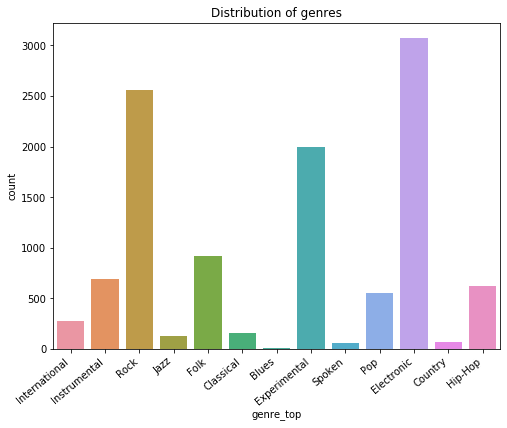

In [18]:
fig = plt.figure(figsize=(8,6))
ax = sns.barplot(x="genre_top", y="count", data=check_balance)
ax.set_title("Distribution of genres")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

The data is not very balanced, The "Rock" label, "Electorinic' label and 'Experimental' label take up 70% among all labels and all other label types only take up 30%.

### 2. Check the collinearity of features

#### The features we selected for supervised learning temporarily:
 
1. chroma_cens1
2. chroma_cqt85
3. chroma_stft169
4. mfcc253
5. spectral_bandwidth400
6. spectral_centroid407
7. spectral_contrast414
8. spectral_rolloff463
9. tonnetz470
10. zcr512

In [19]:
features = ['chroma_cens1', 'chroma_cqt85', 'chroma_stft169', 'mfcc253', 'spectral_bandwidth400',
           'spectral_centroid407', 'spectral_contrast414', 'spectral_rolloff463', 'tonnetz470', 
           'zcr512']

myGraph=cleaned_df[features]
for col in features:
    myGraph = myGraph.withColumn(col,myGraph[col].cast(DoubleType()))

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=features, 
                            outputCol=vector_col)
myGraph_vector = assembler.transform(myGraph).select(vector_col)
matrix = Correlation.corr(myGraph_vector, vector_col)

matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray()

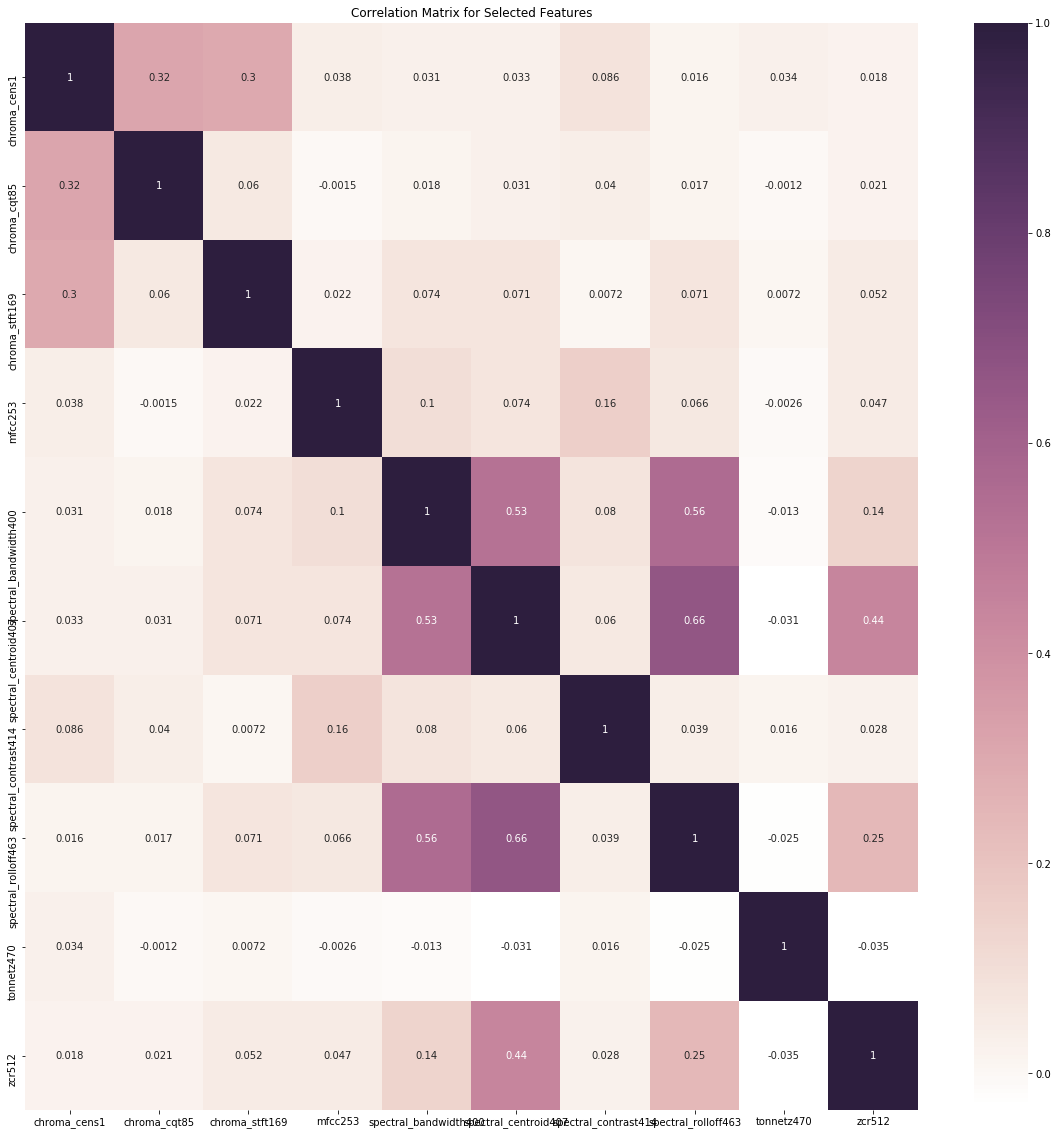

In [20]:
fig = plt.figure(figsize=(20,20))
cmap = sns.cubehelix_palette(light=1, as_cmap = True)
ax = sns.heatmap(corrmatrix, annot=True, cmap = cmap)
ax.set_title("Correlation Matrix for Selected Features")
ax.set_xticklabels(features)
ax.set_yticklabels(features)
plt.show()

Fome the above correlation plot, we can conclude that feature 'spectral_rolloff463' have a relatively strong and positive relationship with spectral_bandwidth400' and 'spectral_centroid407', while others are weakly or not correlated. So we decide to exclude this feature when conduct machine learning models.

Therefore, the features selected for now is:

1. chroma_cens1
2. chroma_cqt85
3. chroma_stft169
4. mfcc253
5. spectral_bandwidth400
6. spectral_centroid407
7. spectral_contrast414
8. tonnetz470
9. zcr512

### 3. Check the distribution of features

In [21]:
features = ['chroma_cens1', 'chroma_cqt85', 'chroma_stft169', 'mfcc253', 'spectral_bandwidth400',
           'spectral_centroid407', 'spectral_contrast414', 'tonnetz470', 'zcr512']

In [ ]:
df = cleaned_df.toPandas()

In [ ]:
new_df = pd.DataFrame(df['genre_top'])
for col in features:
    new_df[col] = df[col]

In [ ]:
for col in features:
    new_df[col] = pd.to_numeric(new_df[col], errors='coerce')

In [ ]:
for col in features:
    fig = plt.figure(figsize=(6,4))   
    ax = sns.distplot(new_df[col], hist=False, rug=True)
    ax.set_title(f"Distribution of feature:{col}")
    #ax.set(xlim=(-5, 5))
    plt.show()

From the above plots, we can conclude that the distribution of all features are highly skewed to the right,and there are outliers for each feature, but since there are infinite possible ways to make a song, they are not exactly "outliers", so we will keep those numbers this time.

## Unsupervised Learning: K-means Clustering

### 1. Prepare the data

Remove "spectral_rolloff463" and "genre_top" from our data and convert all data to float. We pretend there are no labels in our data set.

In [ ]:
cols = ['track_id','chroma_cens1', 'chroma_cqt85', 'chroma_stft169', 'mfcc253', 'spectral_bandwidth400',
           'spectral_centroid407', 'spectral_contrast414', 'tonnetz470', 'zcr512']
unsup_df = cleaned_df[cols]
for col in unsup_df.columns:
    unsup_df = unsup_df.withColumn(col,unsup_df[col].cast('float'))

In [ ]:
unsup_df.printSchema()

Drop the null values

In [ ]:
unsup_df = unsup_df.na.drop()

Create a feature vector which stores all features as an array of floats

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

In [ ]:
selected_features = ['chroma_cens1', 'chroma_cqt85', 'chroma_stft169', 'mfcc253', 'spectral_bandwidth400',
           'spectral_centroid407', 'spectral_contrast414', 'tonnetz470', 'zcr512']
vecAssembler = VectorAssembler(inputCols=selected_features, outputCol="features")
df_kmeans = vecAssembler.transform(unsup_df).select("track_id","features")

In [ ]:
df_kmeans.show()

### 2. Optimize choice of k

To optimize k we cluster a fraction of the data for different choices of k and look for an "elbow" in the cost function.

In [ ]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans)

In [ ]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

Look like there is very little gain after k=13 , which is also the number of track genres we have selected, so we stick to that choice when processing the full data set.

### 3. Train the model

In [ ]:
#convert the type of track_id column into integer
from pyspark.sql.types import *
Join_table = Join_table.withColumn("track_id", Join_table["track_id"].cast(IntegerType()))

Once the training has converged we can print out the centroids of the 13 clusters.

In [ ]:
k = 13
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

In [ ]:
Make predictions

### 4. Evaluate the model

Evaluate clustering

In [ ]:
cost = model.computeCost(df_kmeans)
print("Within Set Sum of Squared Errors = " + str(cost))

Evaluate clustering by computing Silhouette score.

* If this number is negative, the data cannot be separated at all.
* Values closer to 1 indicate maximum separation.
* Values close to zero mean the data could barely be separated.

In [ ]:
predictions = model.transform(df_kmeans)

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

The result 0.61 is not bad.

## Supervised Learning Models

Perform some data cleaning and feature processing for training models.

In [ ]:
new_df1 = cleaned_df

In [ ]:
def convert_type(line):
    return float(line)

In [ ]:
convert_udf = udf(convert_type, FloatType())
new_df2 = new_df1.withColumn("chroma_cens1", convert_udf(new_df1.chroma_cens1)).withColumnRenamed("chroma_cens1", "chroma_cens1")
new_df2 = new_df2.withColumn("chroma_cqt85", convert_udf(new_df1.chroma_cqt85)).withColumnRenamed("chroma_cqt85", "chroma_cqt85")
new_df2 = new_df2.withColumn("chroma_stft169", convert_udf(new_df1.chroma_stft169)).withColumnRenamed("chroma_stft169", "chroma_stft169")
new_df2 = new_df2.withColumn("mfcc253", convert_udf(new_df1.mfcc253)).withColumnRenamed("mfcc253", "mfcc253")
new_df2 = new_df2.withColumn("spectral_bandwidth400", convert_udf(new_df1.spectral_bandwidth400)).withColumnRenamed("spectral_bandwidth400", "spectral_bandwidth400")
new_df2 = new_df2.withColumn("spectral_centroid407", convert_udf(new_df1.spectral_centroid407)).withColumnRenamed("spectral_centroid407", "spectral_centroid407")
new_df2 = new_df2.withColumn("spectral_contrast414", convert_udf(new_df1.spectral_contrast414)).withColumnRenamed("spectral_contrast414", "spectral_contrast414")
new_df2 = new_df2.withColumn("tonnetz470", convert_udf(new_df1.tonnetz470)).withColumnRenamed("tonnetz470", "tonnetz470")
new_df2 = new_df2.withColumn("zcr512", convert_udf(new_df1.zcr512)).withColumnRenamed("zcr512", "zcr512")

In [ ]:
new_df2 = new_df2.na.drop()

In [ ]:
new_df3 = new_df2.where((new_df2['genre_top'] == 'International') | (new_df2['genre_top'] == 'Instrumental') 
                        | (new_df2['genre_top'] == 'Rock')
                        | (new_df2['genre_top'] == 'Jazz')  | (new_df2['genre_top'] == 'Pop') 
                        | (new_df2['genre_top'] == 'Folk') | (new_df2['genre_top'] == 'Classical') 
                        | (new_df2['genre_top'] == 'Blues')  | (new_df2['genre_top'] == 'Electronic') 
                        | (new_df2['genre_top'] == 'Experimental') | (new_df2['genre_top'] == 'Spoken')
                        | (new_df2['genre_top'] == 'Country')  | (new_df2['genre_top'] == 'Hip-Hop'))


In [ ]:
cols = ['chroma_cens1', 'chroma_cqt85', 'chroma_stft169', 'mfcc253', 'spectral_bandwidth400',
           'spectral_centroid407', 'spectral_contrast414', 'tonnetz470', 'zcr512', 'genre_top']
new_df3 = new_df3[cols]

### Logistic Regression

In [ ]:
# Create a feature vector by combining all features together using the vectorAssembler method.

vectorAssembler_features = VectorAssembler(inputCols = ['chroma_cens1', 'chroma_cqt85', 'chroma_stft169', 'mfcc253', 'spectral_bandwidth400',
           'spectral_centroid407', 'spectral_contrast414', 'tonnetz470', 'zcr512'], outputCol = 'features')
StringIndexer_type = StringIndexer(inputCol = 'genre_top', outputCol = 'label')

In [ ]:
StringIndexer_type = StringIndexer(inputCol = 'genre_top', outputCol = 'label')

In [ ]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")
pipeline = Pipeline(stages=[vectorAssembler_features, StringIndexer_type])
pipelineFit = pipeline.fit(new_df3)
dataset = pipelineFit.transform(new_df3)
train, test = dataset.randomSplit([0.7, 0.3])
model = lr.fit(train)
predictions = model.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(accuracy)

The accuracy of the logistic regression model is only 0.27 and the performance is very bad, so we train an OneVsRest Logistic Regression model. The idea for OneVsRest Logistic Regression is that for each class, there is a binary classifier: this class or the rest of the class. When doing a multi class classification, choose the class with the highest probability. 

### OneVsRest Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
# instantiate the base classifier.
lr = LogisticRegression(maxIter=10, tol=1e-6, fitIntercept=True)

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr)

# train the multiclass model.
ovrModel = ovr.fit(train)

# score the model on test data.
predictions = ovrModel.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(accuracy)

In [ ]:
test_array = [int(row.label) for row in test.collect()]
pred_array = [int(row.prediction) for row in predictions.collect()]
cm = confusion_matrix(test_array, pred_array)

In [ ]:
fig = plt.figure(figsize=(20,20))
ax = sns.heatmap(cm, annot=True, ax = ax)
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

The accuracy of the OneVsRest Logistic Regression model is 0.344, and the performance is better than logistic regression but still not ideal, so we train a decision tree model to see how it goes.  

In [ ]:
### Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier


In [ ]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model = dt.fit(train)
predictions = model.transform(test)
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(accuracy)

In [ ]:
test_array = [int(row.label) for row in test.collect()]
pred_array = [int(row.prediction) for row in predictions.collect()]
cm = confusion_matrix(test_array, pred_array)

In [ ]:
fig = plt.figure(figsize=(20,20))
ax = sns.heatmap(cm, annot=True, ax = ax)
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

The accuracy of the decision tree model is 0.37 and the performance is the best among all three supervised learning models we have trained. 

In [ ]:
sc.stop()